In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
import itertools

In [3]:
tf.compat.v1.disable_eager_execution()

# Load data

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
spec_file =  os.path.join(os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli/'), 'spec_star_restricted.p')

In [6]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [7]:
spec_df.tail()

,stim,id,wav,spec
3067,fh,124,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.55682534, -0.6060915, -0.6800735, -0.5795..."
3068,fh,125,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5762845, -0.6195225, -0.5774481, -0.63291..."
3069,fh,126,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5653498, -0.58962816, -0.6303803, -0.6005..."
3070,fh,127,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.4790637, -0.5114642, -0.62183285, -0.6796..."
3071,fh,128,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.5208054, -0.5728106, -0.62339747, -0.6818..."


In [8]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

186 76


In [9]:
spec_list = spec_df.spec.values.tolist()

In [10]:
n_slices = (4, 1)

# This notebook is on only horizontal slices (spectral slices)

## Define model

In [10]:
clear_session()

## parse inputs and outputs

In [14]:
input_list = []
output_list = []

for spec in spec_list:
    slice_list, index_list = slice_matrix(spec, 
                                          n_slices=n_slices, 
                                          slice_shape=(45, 70))
    input_list.append(slice_list)
    output_list.append(index_list)

In [15]:
input_data = np.array(input_list)

In [16]:
input_data = np.transpose(input_data, (1, 0, 2, 3, 4))

In [17]:
input_data = list(input_data)

In [18]:
output_data = np.array(output_list)

In [19]:
output_data.shape

(3072, 4)

In [20]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_list, test_size = 0.1, 
                                                                      random_state=20)

In [21]:
n_train, _, h, w, _ = np.array(input_train).shape

In [22]:
print(n_train, h, w)

2764 45 70


In [23]:
model=self_VGG()

## connect dense layers and input/output

In [24]:
model_inputs = []
for i in range(np.product(n_slices)):
    model_inputs.append(Input(shape=(h, w, 3)))

In [25]:
encodings = []
for i in range(np.product(n_slices)):
    resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs[i])
    encodings.append(model(resized))
concated = layers.Concatenate(axis=1)(encodings)
dense = layers.Dense(4096)(concated)
model_output = layers.Dense(np.product(n_slices))(dense) # this needs to be changed for both temporal and spectral slices
cfn = Model(model_inputs, model_output)

In [26]:
cfn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45, 70, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 45, 70, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 45, 70, 3)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 45, 70, 3)]  0                                            
_______________________________________________________________________________________

In [27]:
cfn.compile(loss='mse', optimizer = Adam(0.000001)) # need to figure out how to implement FY loss

## train the model to sort spectral slices order

In [28]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()))
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model trained on spectral slicing of morph songs in star scale (restricted), 4 slices')

In [29]:
patience = 20
batch_size = 32
epochs = 1000

In [ ]:
model_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
            ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]

cfn.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 2764 samples, validate on 308 samples
Epoch 1/1000
2764/2764 [==============================] - ETA: 0s - loss: 3.4603WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2764/2764 [==============================] - 87s 31ms/sample - loss: 3.4603 - val_loss: 3.3300
Epoch 2/1000
2764/2764 [==============================] - 85s 31ms/sample - loss: 2.1972 - val_loss: 1.2528
Epoch 3/1000
2764/2764 [==============================] - 87s 31ms/sample - loss: 1.2431 - val_loss: 1.2382
Epoch 4/1000
2764/2764 [==============================] - 87s 31ms/sample - loss: 1.2276 - val_loss: 1.2194
Epoch 5/1000
2764/2764 [==============================] - 86s 31ms/sample

In [ ]:
pickle.dump([input_data, output_data], open(os.path.join(run_folder, 'train_data.p'), 'wb'))

In [38]:
cfn.load_weights(model_file)

In [39]:
input_test = np.array(input_test)

In [40]:
print(input_test.shape)

(2100, 4, 55, 224, 3)


In [41]:
input_test = list(input_test.transpose((1,0,2,3,4)))

In [42]:
prediction_test = cfn.predict(input_test)

In [43]:
prediction_test[0]

array([2.9103746 , 0.08705732, 1.0124377 , 1.980084  ], dtype=float32)

## prediction error (rmse)

In [44]:
print(np.sqrt(np.mean(np.square(prediction_test-output_test))))

0.07441241390426787


In [189]:
del cfn

In [45]:
prediction_test_int = np.round(prediction_test)

In [46]:
print(prediction_test_int[1])

[2. 0. 3. 1.]


In [47]:
print(np.mean(prediction_test_int==output_test))

1.0


# fine tune on stim classification

Groups:
1. ABCD vs EFGH
2. ABGH vs EFCD
3. ABEF vs CDGH

### First we make sure AE1 and AG1 are the same thing

In [11]:
spec_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31604236, -0.37852764, -0.4818401, -0.593..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.29399142, -0.3769715, -0.47865176, -0.570..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.2979087, -0.3694466, -0.47737938, -0.5982..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31531733, -0.36380786, -0.47053644, -0.59..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31867203, -0.36792934, -0.4731297, -0.597..."


In [12]:
AE1 = spec_df[(spec_df['stim']=='ae') & (spec_df['id']==1)].spec.tolist()[0]

In [13]:
AF1 = spec_df[(spec_df['stim']=='af') & (spec_df['id']==1)].spec.tolist()[0]

In [14]:
AC1 = spec_df[(spec_df['stim']=='ac') & (spec_df['id']==1)].spec.tolist()[0]

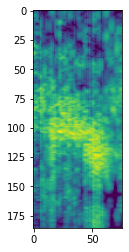

In [15]:
plt.imshow(AE1)

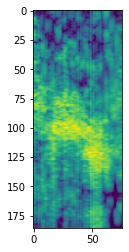

In [16]:
plt.imshow(AF1)

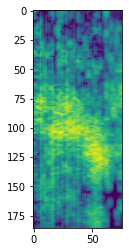

In [17]:
plt.imshow(AC1)

In [18]:
AC128 = spec_df[(spec_df['stim']=='ac') & (spec_df['id']==128)].spec.tolist()[0]

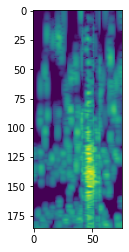

In [19]:
plt.imshow(AC128)

In [20]:
BC128 = spec_df[(spec_df['stim']=='bc') & (spec_df['id']==128)].spec.tolist()[0]

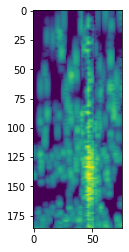

In [21]:
plt.imshow(BC128)

In [31]:
CG1 = spec_df[(spec_df['stim']=='cg') & (spec_df['id']==1)].spec.tolist()[0]

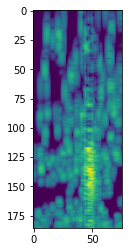

In [32]:
plt.imshow(CG1)

It seems the specific numbers of each specgram might be different but the image refers to the same stim

# Let's show all specgram combinations

In [61]:
list(range(0, 144, 16))

[0, 16, 32, 48, 64, 80, 96, 112, 128]

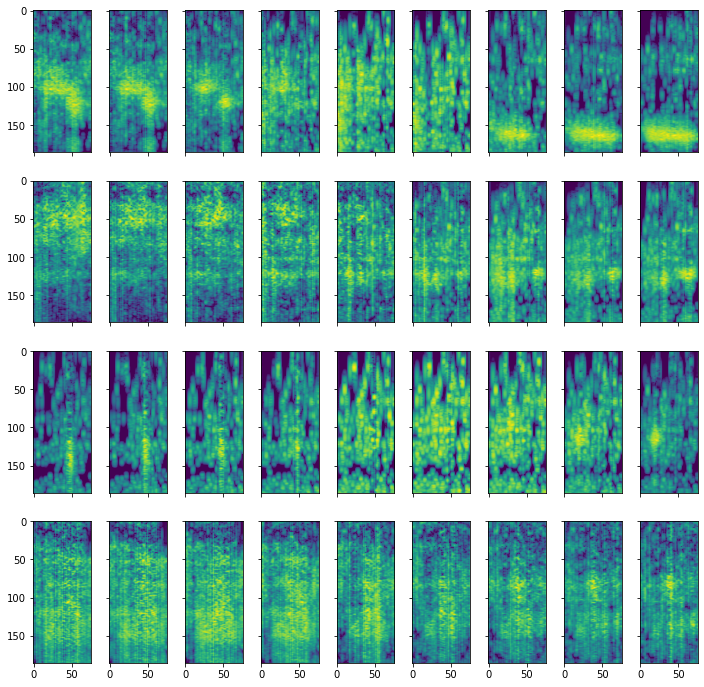

In [64]:
fig, ax = plt.subplots(4, 9, figsize=(12, 12), sharex=True, sharey=True)
row = 0
col = 0
for combo in ['ae', 'bf', 'cg', 'dh']:
    for i in [1]+list(range(16, 144, 16)):
        spec_i = spec_df[(spec_df['stim']==combo) & (spec_df['id']==i)].spec.tolist()[0]
        ax[row][col].imshow(spec_i)
        col+=1
    row+=1
    col = 0

## 1. ABCD vs EFGH

### make inputs and outputs

In [65]:
spec_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31604236, -0.37852764, -0.4818401, -0.593..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.29399142, -0.3769715, -0.47865176, -0.570..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.2979087, -0.3694466, -0.47737938, -0.5982..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31531733, -0.36380786, -0.47053644, -0.59..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.31867203, -0.36792934, -0.4731297, -0.597..."


In [67]:
left_stims = 'abcd'
right_stims = 'efgh'

In [70]:
list(itertools.product(left_stims, right_stims))

[('a', 'e'),
 ('a', 'f'),
 ('a', 'g'),
 ('a', 'h'),
 ('b', 'e'),
 ('b', 'f'),
 ('b', 'g'),
 ('b', 'h'),
 ('c', 'e'),
 ('c', 'f'),
 ('c', 'g'),
 ('c', 'h'),
 ('d', 'e'),
 ('d', 'f'),
 ('d', 'g'),
 ('d', 'h')]

In [81]:
np.stack([AE1, AE1, AE1], axis = 2).shape

(186, 76, 3)

In [82]:
# training data
input_list = []
output_list = []
for L, R in itertools.product(left_stims, right_stims):
    L_stim = spec_df[(spec_df['stim']==(L+R)) & (spec_df['id']==1)].spec.tolist()[0]
    input_list.append(np.stack([L_stim]*3, axis=2))
    output_list.append([1, 0])
    R_stim = spec_df[(spec_df['stim']==(L+R)) & (spec_df['id']==128)].spec.tolist()[0]
    input_list.append(np.stack([R_stim]*3, axis=2))
    output_list.append([0, 1])

In [96]:
# validation data
validation_inputs = []
validation_outputs = []
for L, R in itertools.product(left_stims, right_stims):
    L_stim = spec_df[(spec_df['stim']==(L+R)) & (spec_df['id']==2)].spec.tolist()[0]
    validation_inputs.append(np.stack([L_stim]*3, axis=2))
    validation_outputs.append([1, 0])
    R_stim = spec_df[(spec_df['stim']==(L+R)) & (spec_df['id']==127)].spec.tolist()[0]
    validation_inputs.append(np.stack([R_stim]*3, axis=2))
    validation_outputs.append([0, 1])
validation_inputs = np.array(validation_inputs)
validation_outputs = np.array(validation_outputs)

In [83]:
np.unique(output_list, return_counts=True, axis=0)

(array([[0, 1],
        [1, 0]]),
 array([16, 16]))

In [84]:
input_data = np.array(input_list)
output_data = np.array(output_list)

In [85]:
n_samples, n_outputs=output_data.shape

In [86]:
h, w = input_data[0].shape[:2]
print(n_samples, n_outputs, h, w)

32 2 186 76


### make model

In [130]:
clear_session()

In [131]:
model=self_VGG()

In [132]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dense_1)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dense_2)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dense_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)

In [133]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 186, 76, 3)]      0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dense3 (Dense)               (None, 1024)              2098176   
_________________________________________________________________
output (Dense)               (None, 2)                

In [134]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_10_12_14_12_13/weights-improvement.h5'),
                       by_name=True)

In [124]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [94]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2021_10_12_14_12_13', 'Group1')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on morph stims in star scale, \
               fine tuned on stim classification Group 1(ABCD vs EFGH), pretrained weights are trainable')

In [117]:
patience = 100
batch_size = 10
epochs = 1000

In [125]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_data=(validation_inputs, validation_outputs))

Train on 32 samples, validate on 32 samples
Epoch 1/1000
32/32 [==============================] - 4s 131ms/sample - loss: 0.8812 - accuracy: 0.4062 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6921 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6896 - accuracy: 0.5625 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.7004 - accuracy: 0.4688 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6965 - accuracy: 0.5312 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 6/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.7032 - accuracy: 0.3438 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6959 -

Epoch 57/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6911 - accuracy: 0.5000 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 58/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6918 - accuracy: 0.5312 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 59/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.7093 - accuracy: 0.4688 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 60/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 61/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6975 - accuracy: 0.4688 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 62/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.7057 - accuracy: 0.4688 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 63/1000
32/32 [==============================] - 0s 10ms/sample - loss: 0.6941 - accuracy: 0.4688 - val_loss: 0.6943 -

In [38]:
classifier.load_weights(weights_file)
prediction_test = classifier.predict(input_test)

In [39]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [40]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [41]:
np.mean(prediction_logits==output_logits)

0.825952380952381

# Cluster features

## first on only pretraining features

### short specs

In [15]:
divided_w = spec_w//3

In [27]:
short_list = []

for spec in spec_list:
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        short_list.append(np.stack([s, s, s], axis = 2))

In [28]:
short_list = np.array(short_list)

In [25]:
clear_session()

In [17]:
model=self_VGG()

In [18]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model_inputs = Input(shape=(spec_h, divided_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [20]:
weights_file = os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5')

In [21]:
classifier.load_weights(weights_file, by_name=True)

In [37]:
embeddings = classifier.predict(short_list)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [38]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings)

subj_list = list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in subj_list))

<AxesSubplot:>

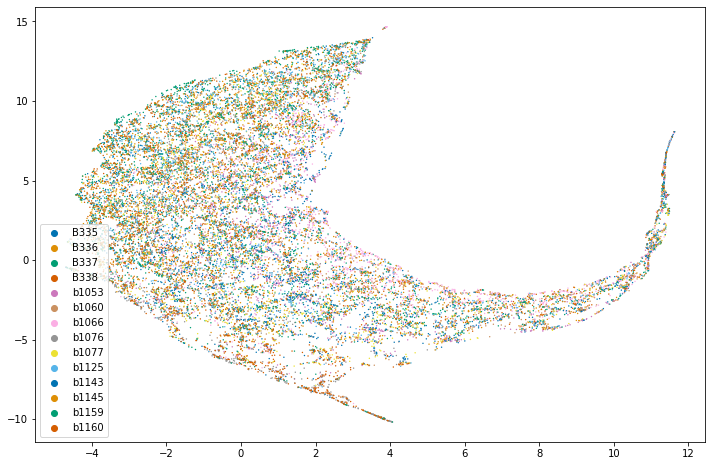

In [39]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')

### long specs

In [22]:
long_list = []
for spec in spec_list:
    long_list.append(np.stack([spec, spec, spec], axis = 2))

In [23]:
long_list = np.array(long_list)

In [26]:
clear_session()

In [27]:
model=self_VGG()

In [28]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
model_inputs = Input(shape=(spec_h, spec_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [30]:
weights_file = os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5')

In [31]:
classifier.load_weights(weights_file, by_name=True)

In [32]:
embeddings = classifier.predict(long_list)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subj_list_num = le.fit_transform(subj_list)

In [40]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings, y=subj_list_num)

<AxesSubplot:>

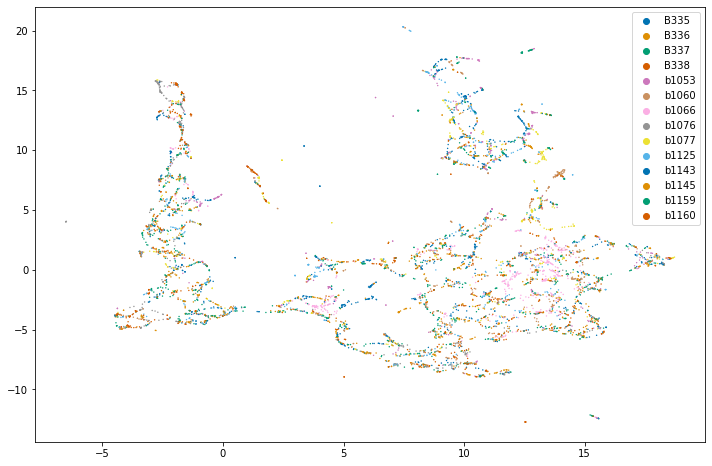

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')